In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

[utils.py:54 - get_tautomer_transformation()] Index of atom that moves: 11.
[utils.py:60 - get_tautomer_transformation()] Index of atom that donates hydrogen: 2
[utils.py:78 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 5


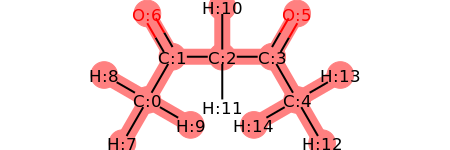

In [2]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit molhttp://localhost:8888/notebooks/notebooks/testing-hybrid-structures.ipynb#
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
neutromeratio.generate_hybrid_structure(ani_input, tautomer_transformation, neutromeratio.ani.ANI1_force_and_energy)

In [3]:
alchemical_atoms=[tautomer_transformation['acceptor_hydrogen_idx'], tautomer_transformation['donor_hydrogen_idx']]

In [4]:
tautomer_transformation

{'donor_idx': 2,
 'hydrogen_idx': 11,
 'acceptor_idx': 5,
 'donor_hydrogen_idx': 11,
 'acceptor_hydrogen_idx': 15}

In [5]:
np.random.seed(0)

# extract hydrogen donor idx and hydrogen idx for from_mol
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalSingleTopologyANI(device=device, alchemical_atoms=alchemical_atoms, ani_input=ani_input)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
ani_trajs = []
n_steps = 1000
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['hybrid_atoms'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation)
energy_function.restrain_acceptor = True
energy_function.restrain_donor = True

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['hybrid_atoms'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

x0 = np.array(ani_input['hybrid_coords']) * unit.angstrom
energie_list = []


for lamb in np.linspace(0, 1, 5):
    print(lamb)
    energy_function.lambda_value = lamb
    
    equilibrium_samples, energies = langevin.run_dynamics(x0, n_steps)
    energie_list.append(energies)
    equilibrium_samples = [x / unit.nanometer for x in equilibrium_samples]
    ani_traj = md.Trajectory(equilibrium_samples, ani_input['hybrid_topolog'])

    ani_trajs.append(ani_traj)

0.0
0.25
0.5
0.75
1.0


In [14]:
import nglview
nglview.show_mdtraj(ani_trajs[0])

NGLWidget(count=1001)

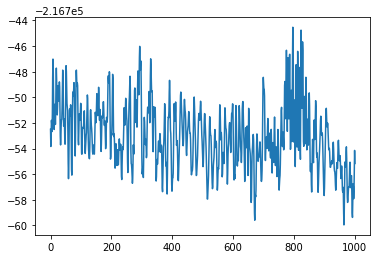

In [7]:
import matplotlib.pyplot as plt
e = [x / unit.kilocalorie_per_mole for x in energie_list[0]]

plt.plot(e)